In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Config do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

## Despesas e Lucro da Empresa

| Coluna           | Descrição                                                                 |
|------------------|---------------------------------------------------------------------------|
| **R&D Spend**     | Valor gasto com **pesquisa e desenvolvimento** (Research & Development). |
| **Administration** | Valor gasto com **atividades administrativas** da empresa.                |
| **Marketing Spend** | Valor gasto em **marketing** dos produtos da empresa.                     |
| **State**          | **Estado** onde a empresa está localizada (`New York`, `California` ou `Florida`). |
| **Profit**         | **Lucro** obtido pela empresa. É a variável alvo (dependente).           |


In [5]:
df = pd.read_csv("50_Startups.xls")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
# Verificando se existem linhas duplicas no dataframe
print("DUPLICADAS?\n",df.duplicated().any())
print("\nIS NULL?\n",df.isnull().sum())

DUPLICADAS?
 False

IS NULL?
 R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64


In [7]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,73721.62,121344.64,211025.10,112012.64
std,45902.26,28017.80,122290.31,40306.18
min,0.00,51283.14,0.00,14681.40
25%,39936.37,103730.88,129300.13,90138.90
50%,73051.08,122699.79,212716.24,107978.19
75%,101602.80,144842.18,299469.08,139765.98
max,165349.20,182645.56,471784.10,192261.83


In [8]:
# variaveis continuas
var_continuas = ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']
df_continuas = df[var_continuas]

Text(0.5, 1.02, 'Gráficos de Dispersão das Variáveis Contínuas')

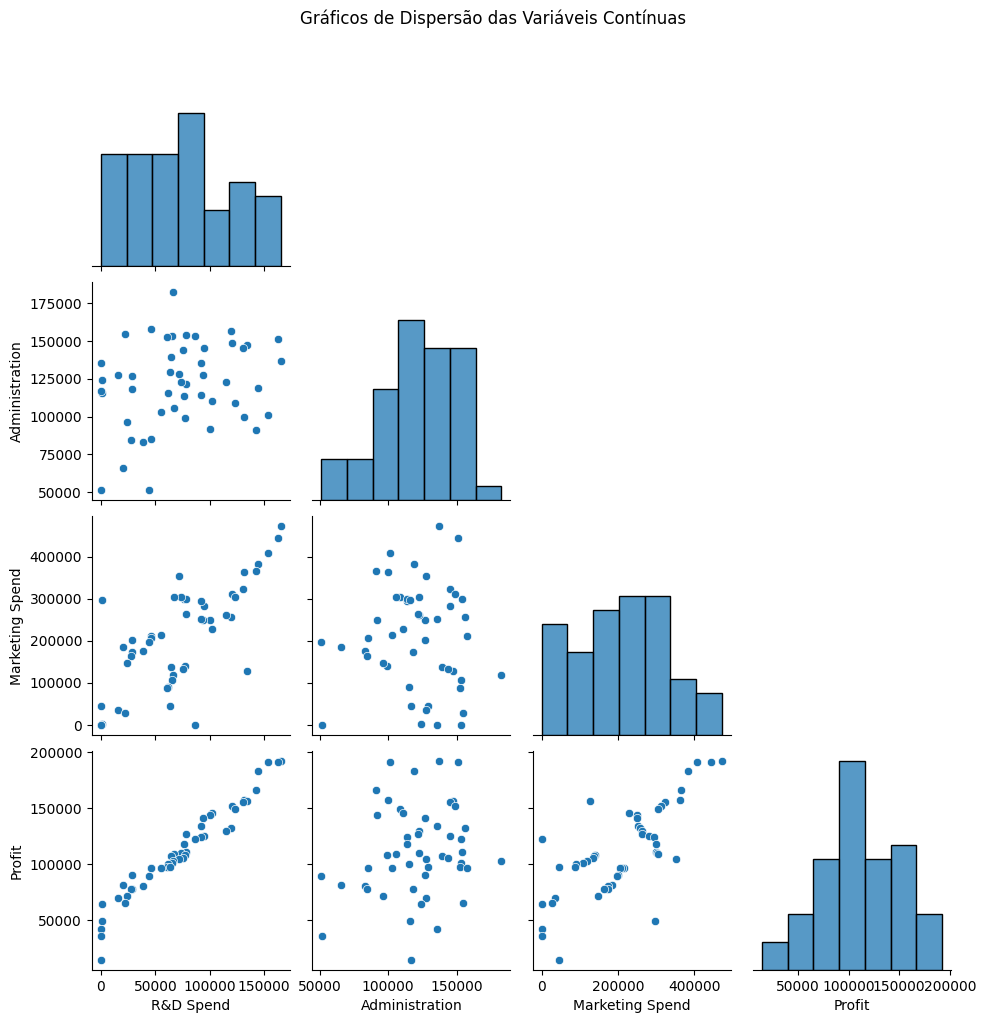

In [9]:
# matriz de dispersão
sns.pairplot(df_continuas, corner=True)
plt.suptitle("Gráficos de Dispersão das Variáveis Contínuas", y=1.02)

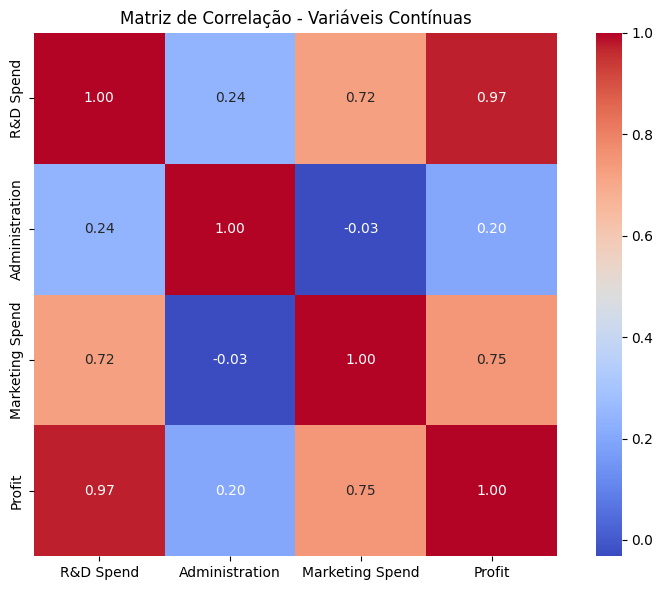

In [10]:
# heatmap
matriz_correlacao = df_continuas.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlação - Variáveis Contínuas")
plt.tight_layout()

## Removendo os Outliers

In [11]:
# calculando quartís
Q1 = df_continuas.quantile(0.25)
Q3 = df_continuas.quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df_continuas[~((df_continuas < (Q1 - 1.5 * IQR)) | (df_continuas > (Q3 + 1.5 * IQR))).any(axis=1)]

In [12]:
# 1 linha removida (outlier)
print(f"original: {df_continuas.shape[0]}")
print(f"sem outliers: {df_no_outliers.shape[0]}")

original: 50
sem outliers: 49


## Trinamento do Modelo de Regressão Linear

- `Profit` - variavel dependente (contínua) - `Y`
- `R&D Spend` e `Marketing Spend` independentes (contínuas) - `X`

In [13]:
X = df_no_outliers[['R&D Spend', 'Marketing Spend']]
y = df_no_outliers['Profit']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Criar e treinar o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# predições
y_pred = modelo.predict(X_test)

## Avaliação do Modelo


In [16]:
# avaliação do modelo
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)
print("R² (teste):", r2_score(y_test, y_pred))
print("Erro quadrático médio:", mean_squared_error(y_test, y_pred))

Coeficientes: [0.75712126 0.04017681]
Intercepto: 48328.71857145497
R² (teste): 0.9222112019138413
Erro quadrático médio: 63115447.56774235


- A cada 1 unidade a mais investida em P&D, o lucro aumenta em média **0.76 unidades**, mantendo os outros fatores constantes.
- A cada 1 unidade a mais em marketing, o lucro aumenta em média **0.04 unidades**.

In [17]:
import plotly.graph_objects as go
import numpy as np

# Dados reais
x = df_no_outliers['R&D Spend']
y = df_no_outliers['Marketing Spend']
z = df_no_outliers['Profit']

# Malha de predição (superfície)
x_surf, y_surf = np.meshgrid(
    np.linspace(x.min(), x.max(), 30),
    np.linspace(y.min(), y.max(), 30)
)

# Z predito pela regressão
z_surf = modelo.intercept_ + modelo.coef_[0]*x_surf + modelo.coef_[1]*y_surf

# Gráfico
fig = go.Figure()

# Pontos reais
fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Dados Reais'
))

# Superfície do plano de regressão
fig.add_trace(go.Surface(x=x_surf, y=y_surf, z=z_surf,
    opacity=0.5,
    colorscale='Viridis',
    name='Plano de Regressão'
))

fig.update_layout(
    title='Regressão Linear Múltipla - Gráfico 3D Interativo',
    scene=dict(
        xaxis_title='R&D Spend',
        yaxis_title='Marketing Spend',
        zaxis_title='Profit'
    )
)

fig.write_html("grafico_regressao_3d.html")

In [18]:
coeficientes = modelo.coef_
intercepto = modelo.intercept_

print("Equação da regressão:")
equacao = "y = {:.2f}".format(intercepto)
for i, coef in enumerate(coeficientes):
    equacao += " + {:.2f}*x{}".format(coef, i+1)
print(equacao)

Equação da regressão:
y = 48328.72 + 0.76*x1 + 0.04*x2


In [19]:
from sklearn.feature_selection import f_regression

f_values, _ = f_regression(X_train, y_train)

for feature, f_val in zip(X_train.columns, f_values):
    print(f"{feature}: {f_val:.2f}")

R&D Spend: 820.90
Marketing Spend: 49.58


In [24]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)

modelo_ols = sm.OLS(y_train, X_train_const).fit()

for nome, pval in zip(X_train_const.columns, modelo_ols.pvalues):
    print(f"{nome}: {pval:.20f}")

const: 0.00000000000000000414
R&D Spend: 0.00000000000000000001
Marketing Spend: 0.01901880747381678310


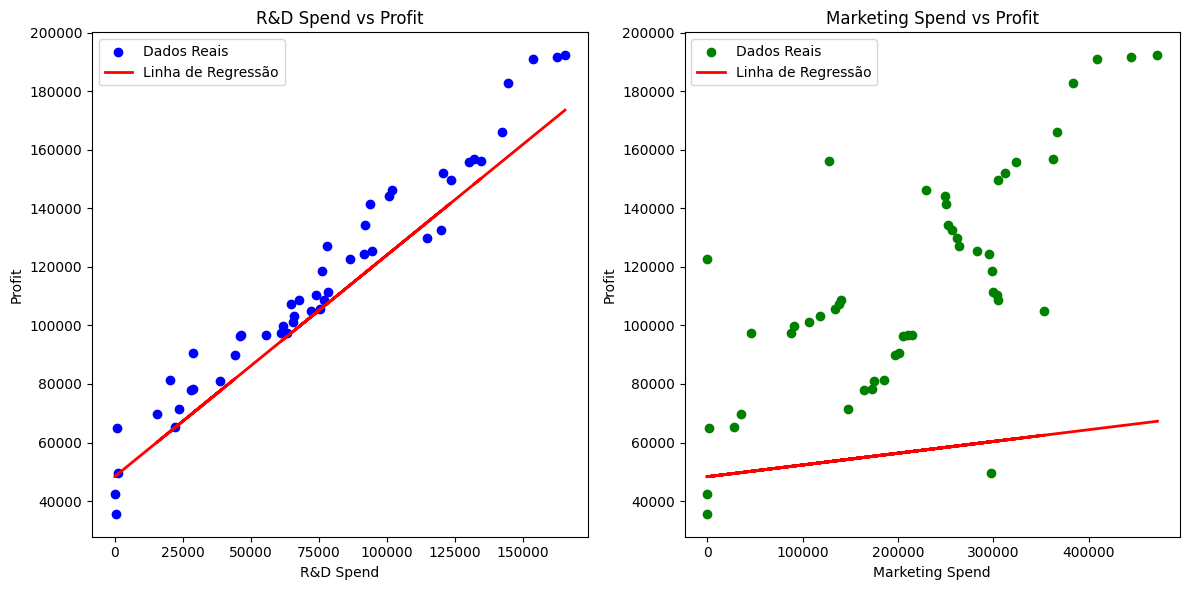

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Gráfico 1: R&D Spend vs Profit
plt.figure(figsize=(12, 6))

# Plotando os dados reais
plt.subplot(1, 2, 1)
plt.scatter(x, z, color='blue', label='Dados Reais')
plt.plot(x, modelo.intercept_ + modelo.coef_[0] * x, color='red', label='Linha de Regressão', linewidth=2)
plt.title('R&D Spend vs Profit')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.legend()

# Gráfico 2: Marketing Spend vs Profit
plt.subplot(1, 2, 2)
plt.scatter(y, z, color='green', label='Dados Reais')
plt.plot(y, modelo.intercept_ + modelo.coef_[1] * y, color='red', label='Linha de Regressão', linewidth=2)
plt.title('Marketing Spend vs Profit')
plt.xlabel('Marketing Spend')
plt.ylabel('Profit')
plt.legend()

# Exibir os gráficos
plt.tight_layout()
plt.show()
